In [32]:
!pip3 install sortednp memory_profiler

You should consider upgrading via the 'c:\users\valentun\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# ARS97 Algorithm implementation

In [33]:
import numpy as np
from numpy import ndarray
import sortednp
from typing import List

import matplotlib.pyplot as plt

In [34]:
def is_power_of_two(n):
    return (n != 0) and (n & (n-1) == 0)

def merge_sorted(arrays: List[ndarray]):
    result = arrays[0]

    # noinspection PyStatementEffect
    [result := sortednp.merge(result, x) for x in arrays[1:]]

    return result

def split(arr, cond):
  return [arr[cond], arr[~cond]]

In [35]:
class ARS97:

    def __init__(self, data, m, s):
        n = len(data)

        # restrictions from the paper for efficient sample phase algorithm
        # assert n % m == 0
        assert is_power_of_two(s)
        assert is_power_of_two(m)
        assert m % s == 0 # implied from the fact that s and m are powers of two but corner case is m < s

        self.n = n # size of the data
        self.m = m # size of the run
        self.s = s # number of sample points for each run
        self.r = n // m
        self.data = data

        self.sample_points = self.__sample()


    def __sample(self) -> ndarray:
        runs = np.array_split(self.data, self.r)
        # print(f"{runs=}")

        sample_points_by_run = list(map(self.__sample_run, runs))
        # print(f"{sample_points_by_run=}")
        all_sample_points = merge_sorted(sample_points_by_run)
        # print(f"{all_sample_points=}")

        assert np.all(np.diff(all_sample_points) >= 0) # all_sample_points should be sorted

        return all_sample_points

    def quantile_upper(self, quantile_fraction: float):
        assert 0 < quantile_fraction < 1

        rank = self.n * quantile_fraction
        index = rank * self.s / self.m

        return self.sample_points[int(index)]

    def quantile_lower(self, quantile_fraction: float):
        assert 0 < quantile_fraction < 1

        rank = self.n * quantile_fraction
        index = self.s / self.m * rank - (self.r - 1) * (1 - self.s / self.m)

        return self.sample_points[int(index)]

    def __sample_run(self, run_data: ndarray) -> ndarray:
        groups = self.__split_run_into_groups(run_data)

        maxes = [np.max(group) for group in groups]

        return np.array(maxes)


    def __split_run_into_groups(self, run_data: ndarray) -> List[ndarray]:
        if len(run_data) <= self.m / self.s:
            return [run_data]

        result = []
        median = np.median(run_data)
        left, right = split(run_data, run_data < median)

        result.extend(self.__split_run_into_groups(left))
        result.extend(self.__split_run_into_groups(right))

        return result


# Compare estimations with real values based on parameters

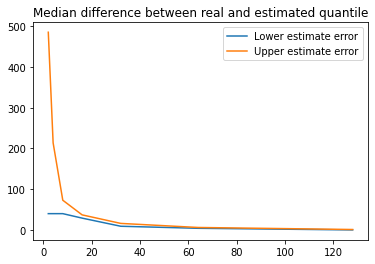

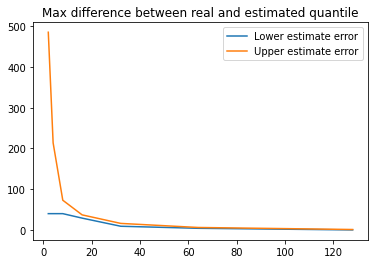

In [36]:
data = np.arange(0, 1024)
np.random.shuffle(data)

quantile = 0.5
real_quantile_value = np.quantile(data, quantile)

test_repeat_times = 100

m_base = 7
m = 2 ** m_base
s_values = np.power(2, np.arange(1, m_base + 1))

median_diff_quantile_lowers, median_diff_quantile_uppers = [], []
max_diff_quantile_lowers, max_diff_median_quantile_uppers = [], []

for s in s_values:
    ars97 = ARS97(data, m=m, s=int(s))

    quantile_lowers_diff, quantile_uppers_diff = [], []

    for i in range(test_repeat_times):
        quantile_lowers_diff.append(real_quantile_value - ars97.quantile_lower(quantile))
        quantile_uppers_diff.append(ars97.quantile_upper(quantile) - real_quantile_value)

    median_diff_quantile_lowers.append(np.median(quantile_lowers_diff))
    median_diff_quantile_uppers.append(np.median(quantile_uppers_diff))

    max_diff_quantile_lowers.append(np.max(quantile_lowers_diff))
    max_diff_median_quantile_uppers.append(np.max(quantile_uppers_diff))


def show_estimate_errors(lower, upper, title: str):
    plt.plot(s_values, lower, label="Lower estimate error")
    plt.plot(s_values, upper, label="Upper estimate error")
    plt.legend()
    plt.title(title)
    plt.show()

show_estimate_errors(median_diff_quantile_lowers, median_diff_quantile_uppers, "Median difference between real and estimated quantile")
show_estimate_errors(max_diff_quantile_lowers, max_diff_median_quantile_uppers, "Max difference between real and estimated quantile")

# Measure time complexity

897959183

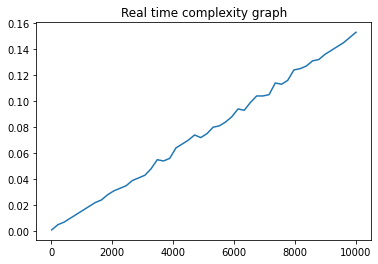

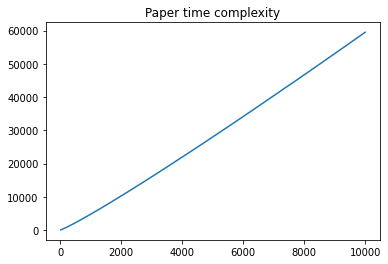

In [37]:
from time import time
from math import log

s = 4
m = 8
n_values = np.linspace(m * 2, 10000)

execution_times = []
paper_complexities = []

def paper_est_complexity(ars97: ARS97):
    return ars97.n + ars97.n * log(ars97.s) + ars97.r * ars97.s * log(ars97.r) + 1

for n in n_values:
    print(f"{n=}", end="\r", flush=True)

    data = np.arange(0, n)
    np.random.shuffle(data)

    start = time()

    ars97 = ARS97(data, m, s)

    ars97.quantile_upper(0.5)
    execution_times.append(time() - start)
    paper_complexities.append(paper_est_complexity(ars97))

plt.plot(n_values, execution_times)
plt.title("Real time complexity graph")
plt.show()

plt.plot(n_values, paper_complexities)
plt.title("Paper time complexity")
plt.show()

As we can see, actual time complexity of algorithm corresponds to the asymptotic complexity described in the paper

# Measure memory complexity

=3243.151515151515n=3444.8484848484845n=3646.5454545454545n=3848.242424242424n=4049.939393939394n=4251.636363636363n=4453.333333333333n=4655.030303030303n=4856.727272727272n=5058.424242424242n=5260.121212121212n=5461.818181818182n=5663.515151515151n=5865.212121212121n=6066.909090909091n=6268.60606060606n=6470.30303030303n=6672.0n=6873.696969696969n=7075.393939393939n=7277.090909090909n=7478.787878787878n=7680.484848484848n=7882.181818181818n=8083.878787878788n=8285.575757575758n=8487.272727272726n=8688.969696969696n=8890.666666666666n=9092.363636363636n=9294.060606060606n=9495.757575757576n=9697.454545454544n=9899.151515151514

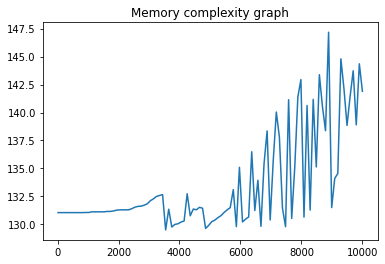

In [38]:
from memory_profiler import memory_usage

n_values = np.linspace(m * 2, 10000, 100)
data = []

def memory_test():
    ars97 = ARS97(data, m, s)
    ars97.quantile_upper(0.5)

memory_usages = []

for n in n_values:
    print(f"{n=}", end="\r", flush=True)
    data = np.arange(n, 0, -1)

    mem_usage = memory_usage(memory_test)
    memory_usages.append(max(mem_usage))


plt.plot(n_values, memory_usages)
plt.title("Memory complexity graph")
plt.show()

While memory graph has severe fluctuations we can still see linear complexity w.r.t input size